In [1]:
# In case you don't have `legume` installed
import sys
sys.path.append('../')

import numpy as np
import legume

import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Asymmetric grating
In this notebook we will reproduce 

In [2]:
# Grating parameters
ymax = 0.1      # ficticious supercell length in y-direction, should be smaller than 1/gmax below
W = 0.45        # width of dielectric rods
H = 1.5         # total height of grating
D = 0.1         # thickness of added parts
Wa = (1-W)/2    # width of added parts
epss = 1.45**2  # permittivity of the rods
epsa = 1.1**2   # permittivity of the added parts

### Build the grating as a three-layer structure

We take a rectangular lattice with a small periodicity in the y-direction. If `ymax < 1/gmax`, then only reciprocal lattice vectors with $G_y = 0$ will be included in the expansion. 

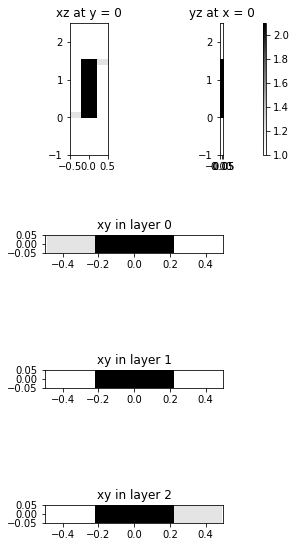

In [3]:
# Initialize the lattice and the PhC
lattice = legume.Lattice([1, 0], [0, ymax])
phc = legume.PhotCryst(lattice)

# First layer
phc.add_layer(d=D, eps_b=epss)
rect_add = legume.Poly(eps=epsa, x_edges=np.array([-0.5, -0.5, -W / 2, -W / 2]),
                     y_edges=np.array([0.5, -0.5, -0.5, 0.5]) * ymax)
rect_air = legume.Poly(eps=1, x_edges=np.array([W / 2, W / 2, 0.5, 0.5]),
                     y_edges=np.array([0.5, -0.5, -0.5, 0.5]) * ymax)
phc.add_shape([rect_add, rect_air])

# Second layer
phc.add_layer(d=H-2*D, eps_b=epss)
rect_air1 = legume.Poly(eps=1, x_edges=np.array([-0.5, -0.5, -W / 2, -W / 2]),
                     y_edges=np.array([0.5, -0.5, -0.5, 0.5]) * ymax)
rect_air2 = legume.Poly(eps=1, x_edges=np.array([W / 2, W / 2, 0.5, 0.5]),
                     y_edges=np.array([0.5, -0.5, -0.5, 0.5]) * ymax)
phc.add_shape([rect_air1, rect_air2])

# Third layer
phc.add_layer(d=D, eps_b=epss)
rect_air = legume.Poly(eps=1, x_edges=np.array([-0.5, -0.5, -W / 2, -W / 2]),
                     y_edges=np.array([0.5, -0.5, -0.5, 0.5]) * ymax)
rect_add = legume.Poly(eps=epsa, x_edges=np.array([W / 2, W / 2, 0.5, 0.5]),
                     y_edges=np.array([0.5, -0.5, -0.5, 0.5]) * ymax)
phc.add_shape([rect_add, rect_air])

# Visualize what we built
legume.viz.structure(phc)

### Compute quasi-guided bands

We first compute the bnads in the entire Brillouin zone.

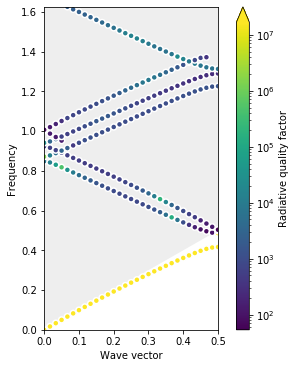

In [4]:
# Make a BZ path along the G-X direction
path = phc.lattice.bz_path(['G', np.array([np.pi, 0])], [30])

neig = 7 # number of Bloch bands to store
gmax = 3 # truncation of reciprocal lattice vectors

# Initialize GME
gme = legume.GuidedModeExp(phc, gmax=gmax)

# Set some of the running options
options = {'gmode_inds': [1, 3, 5, 7], # Take the lowest-frequency TM-mode (in our definition)
           'numeig': neig, 
           'verbose': False, 
           'gmode_step': 1e-3
            }
# Run the simulation
gme.run(kpoints=path.kpoints, **options)

# Visualize the bands
ax = legume.viz.bands(gme, Q=True)

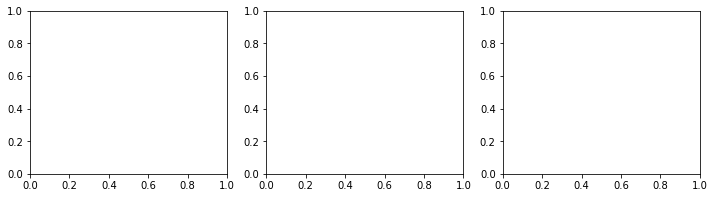

In [5]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3))

In [ ]:
# See the legume README to understand the options below
path = phc.lattice.bz_path(['G', 0.3*np.array([np.pi, 0])], [100])
gme = legume.GuidedModeExp(phc, gmax=6)

options = {'gmode_inds': [1, 3, 5, 7, 9], 'numeig': 4, 'verbose': False, 'gmode_step': 1e-4, 'gmode_tol': 1e-12}

gme.run(kpoints=path.kpoints, **options)

ax = legume.viz.bands(gme, Q=True)

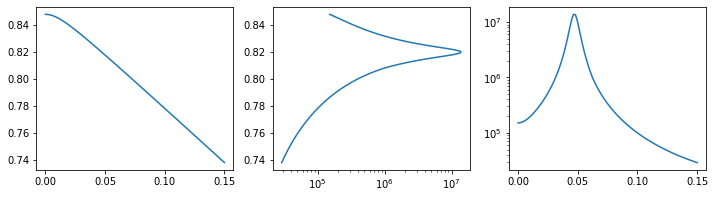

In [5]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3))
indmode = 1
ax[0].plot(gme.kpoints[0, :]/2/np.pi, gme.freqs[:, indmode])
ax[1].plot(gme.freqs[:, indmode]/2/gme.freqs_im[:, indmode], gme.freqs[:, indmode])
ax[1].set_xscale('log')
ax[2].plot(gme.kpoints[0, :]/2/np.pi, gme.freqs[:, indmode]/2/gme.freqs_im[:, indmode])
ax[2].set_yscale('log')

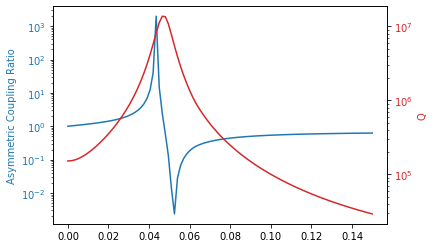

In [6]:
rl = np.array([gme.coup_l[i][1]['tm'] for i in range(gme.kpoints.shape[1])])
ru = np.array([gme.coup_u[i][1]['tm'] for i in range(gme.kpoints.shape[1])])
fig, ax = plt.subplots(1)
color = 'tab:blue'
ax.plot(gme.kpoints[0, :]/2/np.pi, np.abs(rl/ru)**2)
ax.set_yscale('log')
ax.set_ylabel('Asymmetric Coupling Ratio', color=color)
ax.tick_params(axis='y', labelcolor=color)

ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:red'
ax2.plot(gme.kpoints[0, :]/2/np.pi, gme.freqs[:, indmode]/2/gme.freqs_im[:, indmode], color=color)
ax2.set_yscale('log')
ax2.set_ylabel('Q', color=color)
ax2.tick_params(axis='y', labelcolor=color)

In [ ]:
rl = np.array([gme.coup_l[i][1]['tm'] for i in range(gme.kpoints.shape[1])])
ru = np.array([gme.coup_u[i][1]['tm'] for i in range(gme.kpoints.shape[1])])
fig, ax = plt.subplots(1)
color = 'tab:blue'
ax.plot(gme.kpoints[0, :]/2/np.pi, np.abs(rl/ru)**2)
ax.set_yscale('log')
ax.set_ylabel('Asymmetric Coupling Ratio', color=color)
ax.tick_params(axis='y', labelcolor=color)

ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:red'
ax2.plot(gme.kpoints[0, :]/2/np.pi, gme.freqs[:, indmode]/2/gme.freqs_im[:, indmode], color=color)
ax2.set_yscale('log')
ax2.set_ylabel('Q', color=color)
ax2.tick_params(axis='y', labelcolor=color)

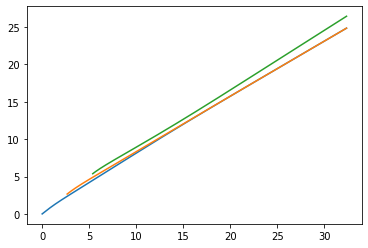

In [114]:
plt.plot(gme.g_array[0][-len(gme.omegas_tm[0][0]):], gme.omegas_tm[0][0])
plt.plot(gme.g_array[0][-len(gme.omegas_tm[0][1]):], gme.omegas_tm[0][1])
plt.plot(gme.g_array[0][-len(gme.omegas_tm[0][2]):], gme.omegas_tm[0][2])

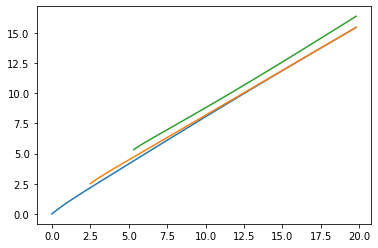

In [118]:
plt.plot(gme.g_array[0][-len(gme.omegas_te[0][0]):], gme.omegas_te[0][0])
plt.plot(gme.g_array[0][-len(gme.omegas_te[0][1]):], gme.omegas_te[0][1])
plt.plot(gme.g_array[0][-len(gme.omegas_te[0][2]):], gme.omegas_te[0][2])